In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
datadir='../Datasets/'

# Part 1 -- generating figures from the book

## Figure 2.1: size of the giant component

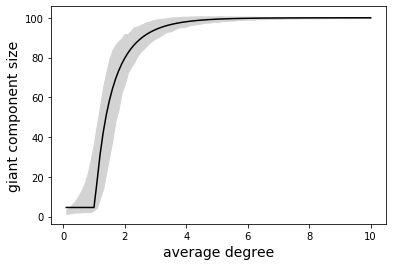

In [2]:
n = 100
#n=10000
gc_avg = []
gc_std = []
REP = 1000
ad = np.arange(.1,10.1,.1)
for d in ad:
    x = []
    for rep in range(REP):
        p = d/(n-1)
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(g.clusters().giant().vcount())
    gc_avg.append(np.mean(x))
    gc_std.append(np.std(x))

## theoretical
th = [np.log(n) for i in np.arange(.1,1.1,.1)]
from scipy.optimize import fsolve
def fn(x,d):
    return x+np.exp(-x*d)-1
for i in np.arange(1.1,10.1,.1):
    th.append(n*fsolve(fn,1,args=(i))[0])

plt.fill_between(ad,[x[0]-1.654*x[1] for x in zip(gc_avg,gc_std)],
                 [x[0]+1.645*x[1] for x in zip(gc_avg,gc_std)],color='lightgray')
plt.plot(ad,th,color='black')
plt.xlabel('average degree',fontsize=14)
plt.ylabel('giant component size',fontsize=14);

## Figure 2.2: P(graph is connected)


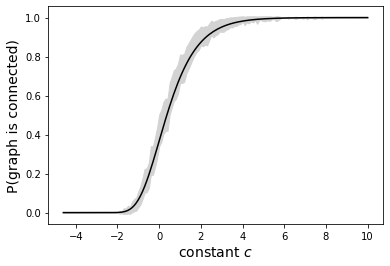

In [3]:
n = 100
#n=10000
REP = 1000
lo = -int(np.floor(np.log(n)*10))/10
if lo<-10:
    lo = -10
C = np.arange(lo,10.1,.1)
ic_avg=[]
for c in C:
    x = []
    for rep in range(REP):
        p = (c+np.log(n))/n
        g = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(int(g.is_connected()))
    ic_avg.append(np.mean(x))

## theoretical
th = [np.exp(-np.exp(-c)) for c in C]

## plot
plt.fill_between(C,[x-1.654*np.sqrt(x*(1-x)/n) for x in ic_avg],
                 [x+1.645*np.sqrt(x*(1-x)/n) for x in ic_avg],color='lightgray')
plt.plot(C,th,color='black')
plt.xlabel(r'constant $c$',fontsize=14)
plt.ylabel('P(graph is connected)',fontsize=14);
#plt.savefig('connected_100.eps');

## Figure 2.4: Distribution of shortest path lengths

In [4]:
sp = []
N = [50,100,200,400,800,1600,3200]
for n in N:
    p = 5/(n-1)
    g = ig.Graph.Erdos_Renyi(n=n, p=p)
    z = g.shortest_paths()
    sp.append([x for y in z for x in y])

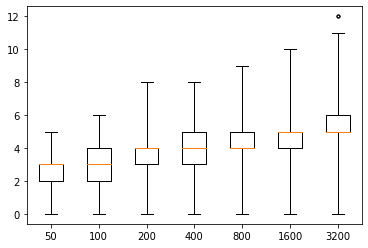

In [5]:
plt.boxplot(sp, labels=N, sym='.',whis=5);
#plt.savefig('path_len.eps')

## Figure 2.5 Poisson vs degree distributions


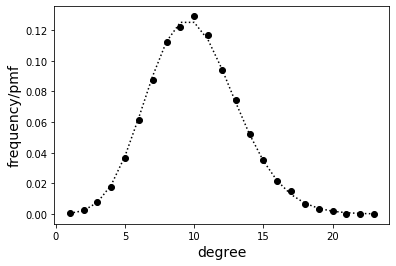

In [6]:
from scipy.stats import poisson
#n=100
n = 10000
p = 10/(n-1)
g = ig.Graph.Erdos_Renyi(n=n, p=p)
x = [x[0] for x in sorted(Counter(g.degree()).items())]
pmf = [poisson.pmf(k,10) for k in x]
frq = [x[1]/n for x in sorted(Counter(g.degree()).items())]
plt.plot(x,frq,'o',color='black')
plt.plot(x,pmf,':',color='black')
plt.xlabel('degree',fontsize=14)
plt.ylabel('frequency/pmf',fontsize=14);


## Figure 2.6 --  Power law graphs

In [7]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples


In [8]:
## power law graph
gamma = 2.5
n = 10000
delta = 1
Delta = np.sqrt(n)
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

deg = [int(np.round(w)) for w in W]
m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)
g1 = ig.Graph.TupleList(tpl)

(9, 2.6905669209114667)


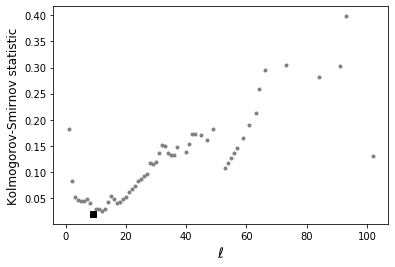

In [9]:
import plfit
d = g1.degree()
X = plfit.plfit(d)
print(X.plfit())
ax = plt.figure(1)
ax = X.xminvsks()
ax.set_xlabel(r'$\ell$',fontsize=14)
ax.set_ylabel('Kolmogorov-Smirnov statistic',fontsize=12);

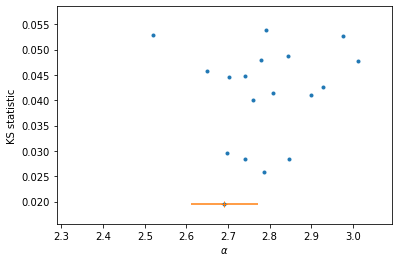

In [10]:
ax = plt.figure(1)
ax = X.alphavsks()

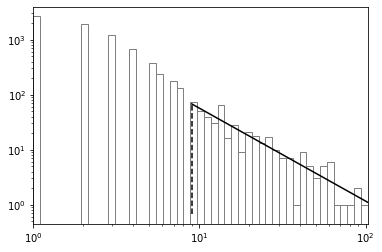

In [11]:
ax = plt.figure(2)
ax = X.plotpdf(plcolor='k',histcolor='grey')


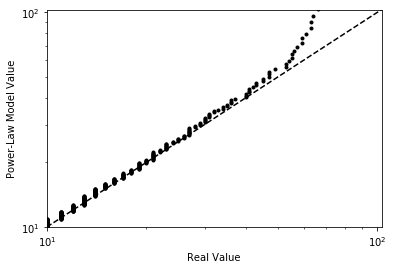

In [12]:
ax = plt.figure(3)
ax = X.plotppf(color='k')

9 2.6905669209114667


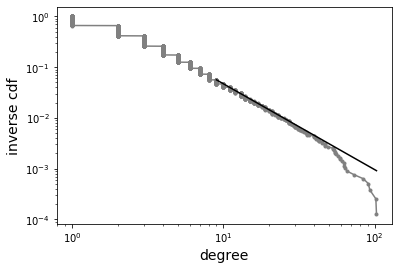

In [13]:
#ax = plt.figure(4)
X.plotcdf(pointcolor='grey', pointmarker='.',zoom=False)


## Figure 2.7: simple d-regular graphs

In [14]:
n = 100
REP = 100
D = np.arange(2,11)
simple = []
for d in D:
    x = 0
    for rep in range(REP):
        g = ig.Graph.Degree_Sequence([d for i in range(n)])
        x += int(g.is_simple())
    simple.append(x/REP)
th = [np.exp(-(d*d-1)/4) for d in D]

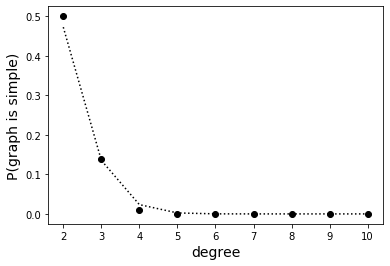

In [15]:
plt.plot(D,simple,'o',color='black')
plt.plot(D,th,':',color='black')
plt.xlabel('degree',fontsize=14)
plt.ylabel('P(graph is simple)',fontsize=14);

## Part 2 -- Experiments section

We consider a real graph and compare some statistics with random graphs. 

## GitHub Developpers (undirected)

Description

A large social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. The task related to the graph is binary node classification - one has to predict whether the GitHub user is a web or a machine learning developer. This target feature was derived from the job title of each user.

Properties

- Nodes: 37,700
- Edges: 289,003
- Transitvity: 0.013


In [16]:
## read the GitHub edge list into a graph (gh)

D = pd.read_csv(datadir+'GitHubDeveloppers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

## Add some node features;
## There are 2 class of nodes
## 0: web developper (red), 1: ml developper (blue)

X = pd.read_csv(datadir+'GitHubDeveloppers/musae_git_target.csv')
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

In [17]:
## for github, 9739 are ml developpers, build the subgraph
gh_ml = gh.subgraph([v for v in gh.vs() if v['color']=='black'])

## keep the giant component
sg = gh_ml.clusters().giant()

In [18]:
## compute some graph stats
S = []
deg = sg.degree()
S.append(['Base Graph',sg.vcount(),sg.ecount(),np.min(deg),np.mean(deg),np.median(deg),
      np.max(deg),sg.diameter(),np.max(sg.clusters().membership)+1,sg.clusters().giant().vcount(),
         sum([x==0 for x in sg.degree()])])


In [19]:
## Random (Erdos-Renyi) graph with same number of nodes and edges
er = ig.Graph.Erdos_Renyi(n=sg.vcount(), m=sg.ecount())
deg = er.degree()
S.append(['Erdos-Renyi',er.vcount(),er.ecount(),np.min(deg),np.mean(deg),np.median(deg),
      np.max(deg),er.diameter(),np.max(er.clusters().membership)+1,er.clusters().giant().vcount(),
         sum([x==0 for x in er.degree()])])


In [20]:
## Random (Chung-Lu) graph with same degree distribution
tpl = fastCL(sg.degree(),sg.ecount()) 
cl = ig.Graph.Erdos_Renyi(n=sg.vcount(),m=0)
cl.add_edges(tpl)
deg = cl.degree()
S.append(['Chung-Lu',cl.vcount(),cl.ecount(),np.min(deg),np.mean(deg),np.median(deg),
      np.max(deg),cl.diameter(),np.max(cl.clusters().membership)+1,cl.clusters().giant().vcount(),
         sum([x==0 for x in cl.degree()])])


In [21]:
## Random (configuration model) graph with same degree distribution
cm = ig.Graph.Degree_Sequence(sg.degree(),method='simple')
deg = cm.degree()
S.append(['Configuration',cm.vcount(),cm.ecount(),np.min(deg),np.mean(deg),np.median(deg),
      np.max(deg),cm.diameter(),np.max(cm.clusters().membership)+1,cm.clusters().giant().vcount(),
         sum([x==0 for x in cm.degree()])])


In [22]:
## Random (configuration model with VL method -- simple graph) graph with same degree distribution
cmvl = ig.Graph.Degree_Sequence(sg.degree(),method='vl')
deg = cmvl.degree()
S.append(['Configuration (VL)',cmvl.vcount(),cmvl.ecount(),np.min(deg),np.mean(deg),np.median(deg),
      np.max(deg),cmvl.diameter(),np.max(cmvl.clusters().membership)+1,cmvl.clusters().giant().vcount(),
         sum([x==0 for x in cmvl.degree()])])


In [23]:
## Compare results
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',
                             r'$d_{median}$',r'$d_{max}$','diameter','components','largest','isolates'])
D = D.transpose()
D

,0,1,2,3,4
graph,Base Graph,Erdos-Renyi,Chung-Lu,Configuration,Configuration (VL)
nodes,7083,7083,7083,7083,7083
edges,19491,19491,19491,19491,19491
$d_{min}$,1,0,0,1,1
$d_{mean}$,5.5036,5.5036,5.5036,5.5036,5.5036
$d_{median}$,2,5,3,2,2
$d_{max}$,482,16,417,482,482
diameter,13,10,9,13,10
components,1,32,1043,58,1
largest,7083,7050,6021,6963,7083


In [24]:
## To produce LaTeX from a DataFrame
#df = D.round(decimals=3)
#print(df.to_latex(index=True))

In [ ]:
%%time
## compute min path length for every node pair for the 5 graphs (real and 4 random ones)
cl_g = cl.clusters().giant()
cm_g = cm.clusters().giant()
# V = np.random.choice(cl_g.vcount(),size=500,replace=False) ## sampling if too slow
V = cl_g.vs() ## all vertices

sp_sg = []
sp_er = []
sp_cl = []
sp_cm = []
sp_cmvl = []
for v in V:
    sp_sg.extend(sg.shortest_paths(source=v)[0])
    sp_er.extend(er.shortest_paths(source=v)[0])
    sp_cl.extend(cl_g.shortest_paths(source=v)[0])
    sp_cm.extend(cm_g.shortest_paths(source=v)[0])
    sp_cmvl.extend(cmvl.shortest_paths(source=v)[0])


In [ ]:
plt.boxplot([sp_sg,sp_er,sp_cl,sp_cm,sp_cmvl],labels=['Base','ER','CL','CM','CM-VL'],sym='.',whis=10, medianprops = dict(linestyle='-', linewidth=2.5, color='black'));
#plt.savefig('pathlen_box.eps');
